# Interaction graph of main characters in The Office U.S 
#### This project is inspired by u/Gandagorn on Reddit 
https://www.reddit.com/user/Gandagorn/
#### Data from Nasir Khalid on Kaggle 
https://www.kaggle.com/nasirkhalid24/the-office-us-complete-dialoguetranscript/notebooks

In [27]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import random
import math
from networkx.utils import py_random_state

## Prepare Data

In [13]:
#%% Prepare data
#Get the data 
office = pd.read_csv('The_Office_lines.csv')
#Create episode_id for comparation later 
office['episode_id'] = office['season'].astype(str)+office['episode'].astype(str)
#get 19 main characters 
main_characters = list(office['speaker'].value_counts().index[:18])

main_characters_suffle = random.sample(main_characters, len(main_characters))
#print(main_characters_suffle)
character_dict = {character: i for i, character in enumerate(main_characters)}
id_dict = {i: character for i, character in enumerate(main_characters)}

In [14]:
#create networkx object
G = nx.Graph()

In [15]:
#%% Get coversation info betwwen characters
scene_before = ""
episode_id_before = -1
for i in range(len(office)):
    #dont need this code from original repo 
    #     # is something spoken?
    #     if office["speaker"].iloc[i] == False or sorted_text_df["speaking_line"].iloc[i] == "false":
    #         # print(sorted_text_df["speaking_line"].iloc[i])
    #         continue

    # check if episode and location of text is the same
    if scene_before != office["scene"].iloc[i] or office["episode_id"].iloc[i] != episode_id_before:
        scene_before = office.iloc[i]["scene"]
        episode_id_before = office.iloc[i]["episode_id"]
        continue

    scene_before = office.iloc[i]["scene"]
    episode_id_before = office.iloc[i]["episode_id"]

    # get characters
    character1 = office["speaker"].iloc[i]
    character2 = office["speaker"].iloc[i+1]
    
    #check if character1 and character 2 is the same
    #NOTE: This method has flaws 
#     m_count = i
#     if character1 == character2:
#         character1 = office["speaker"].iloc[m_count+1]
#         character2 = office["speaker"].iloc[m_count+2]
#         i = m_count + 1

    
    #fail check for character not in the interested list 
    if character1 not in main_characters or character2 not in main_characters:
        continue

    sorted_characters = (character1,character2)
    try:
        #add +1 to weight if characters have conversation on the same sence
        G.edges[sorted_characters]["weight"] += 1
    except KeyError:
        G.add_edge(sorted_characters[0], sorted_characters[1], weight=1)

### Create Dataframe holding interactions weight

In [212]:
df = pd.DataFrame()
df['Weight'] = pd.Series(nx.get_edge_attributes(G,'weight'))
#change from multiindex to single index 
df = df.reset_index(level=[0,1])


In [213]:
#random shuffle the order of characters for easy visulization 
df1 = df.sample(frac=1)
#df1.drop(columns=['index'], axis=1)
df2 = df1.copy()

In [217]:
#remove character character speaks to themself
df2 = df2[df2['level_0'] != df2['level_1']]
df2.reset_index(drop=True)

,level_0,level_1,Weight
0,Jim,Darryl,219
1,Oscar,Toby,43
2,Jan,Phyllis,8
3,Jim,Meredith,83
4,Michael,Oscar,579
...,...,...,...
148,Pam,Kevin,195
149,Oscar,Ryan,36
150,Michael,Kelly,257
151,Jim,Michael,2295


# Plot


In [218]:
G_reorder = nx.from_pandas_edgelist(df2, 'level_0', 'level_1', 'Weight')

In [339]:
def plot_fig_para(G):
    plt.figure(figsize=(40, 40))
    pos = nx.circular_layout(G)
    
    edges = G.edges()

    ################
    colors = [G[u][v]['Weight']**0.09 for u, v in edges]

    weights = [G[u][v]['Weight']**0.45 if G[u][v]['Weight'] > 10 else 0 for u, v in edges]
    

    cmap = matplotlib.cm.get_cmap('Blues')
    #################
    #playing around with different parameters
    # pc = matplotlib.collections.PatchCollection(edges, cmap=cmap)
    # pc.set_array(edge_colors)
    # plt.colorbar(pc)
    #################
    nx.draw_networkx(G, pos, width=weights, edge_color=colors,
                     node_color="white", edge_cmap=cmap, with_labels=False)

    labels_pos = {name: [pos_list[0], pos_list[1]-0.04] for name, pos_list in pos.items()}
    nd = nx.draw_networkx_labels(G, labels_pos, font_size=50, font_family="sans-serif",
                            font_color="#000000", font_weight='bold')

    ax = plt.gca()
    ax.collections[0].set_edgecolor('#000000')
    ax.margins(0.25)
    plt.axis("equal")
    plt.tight_layout()
    #plt.savefig('TheOffice_interactions.png')

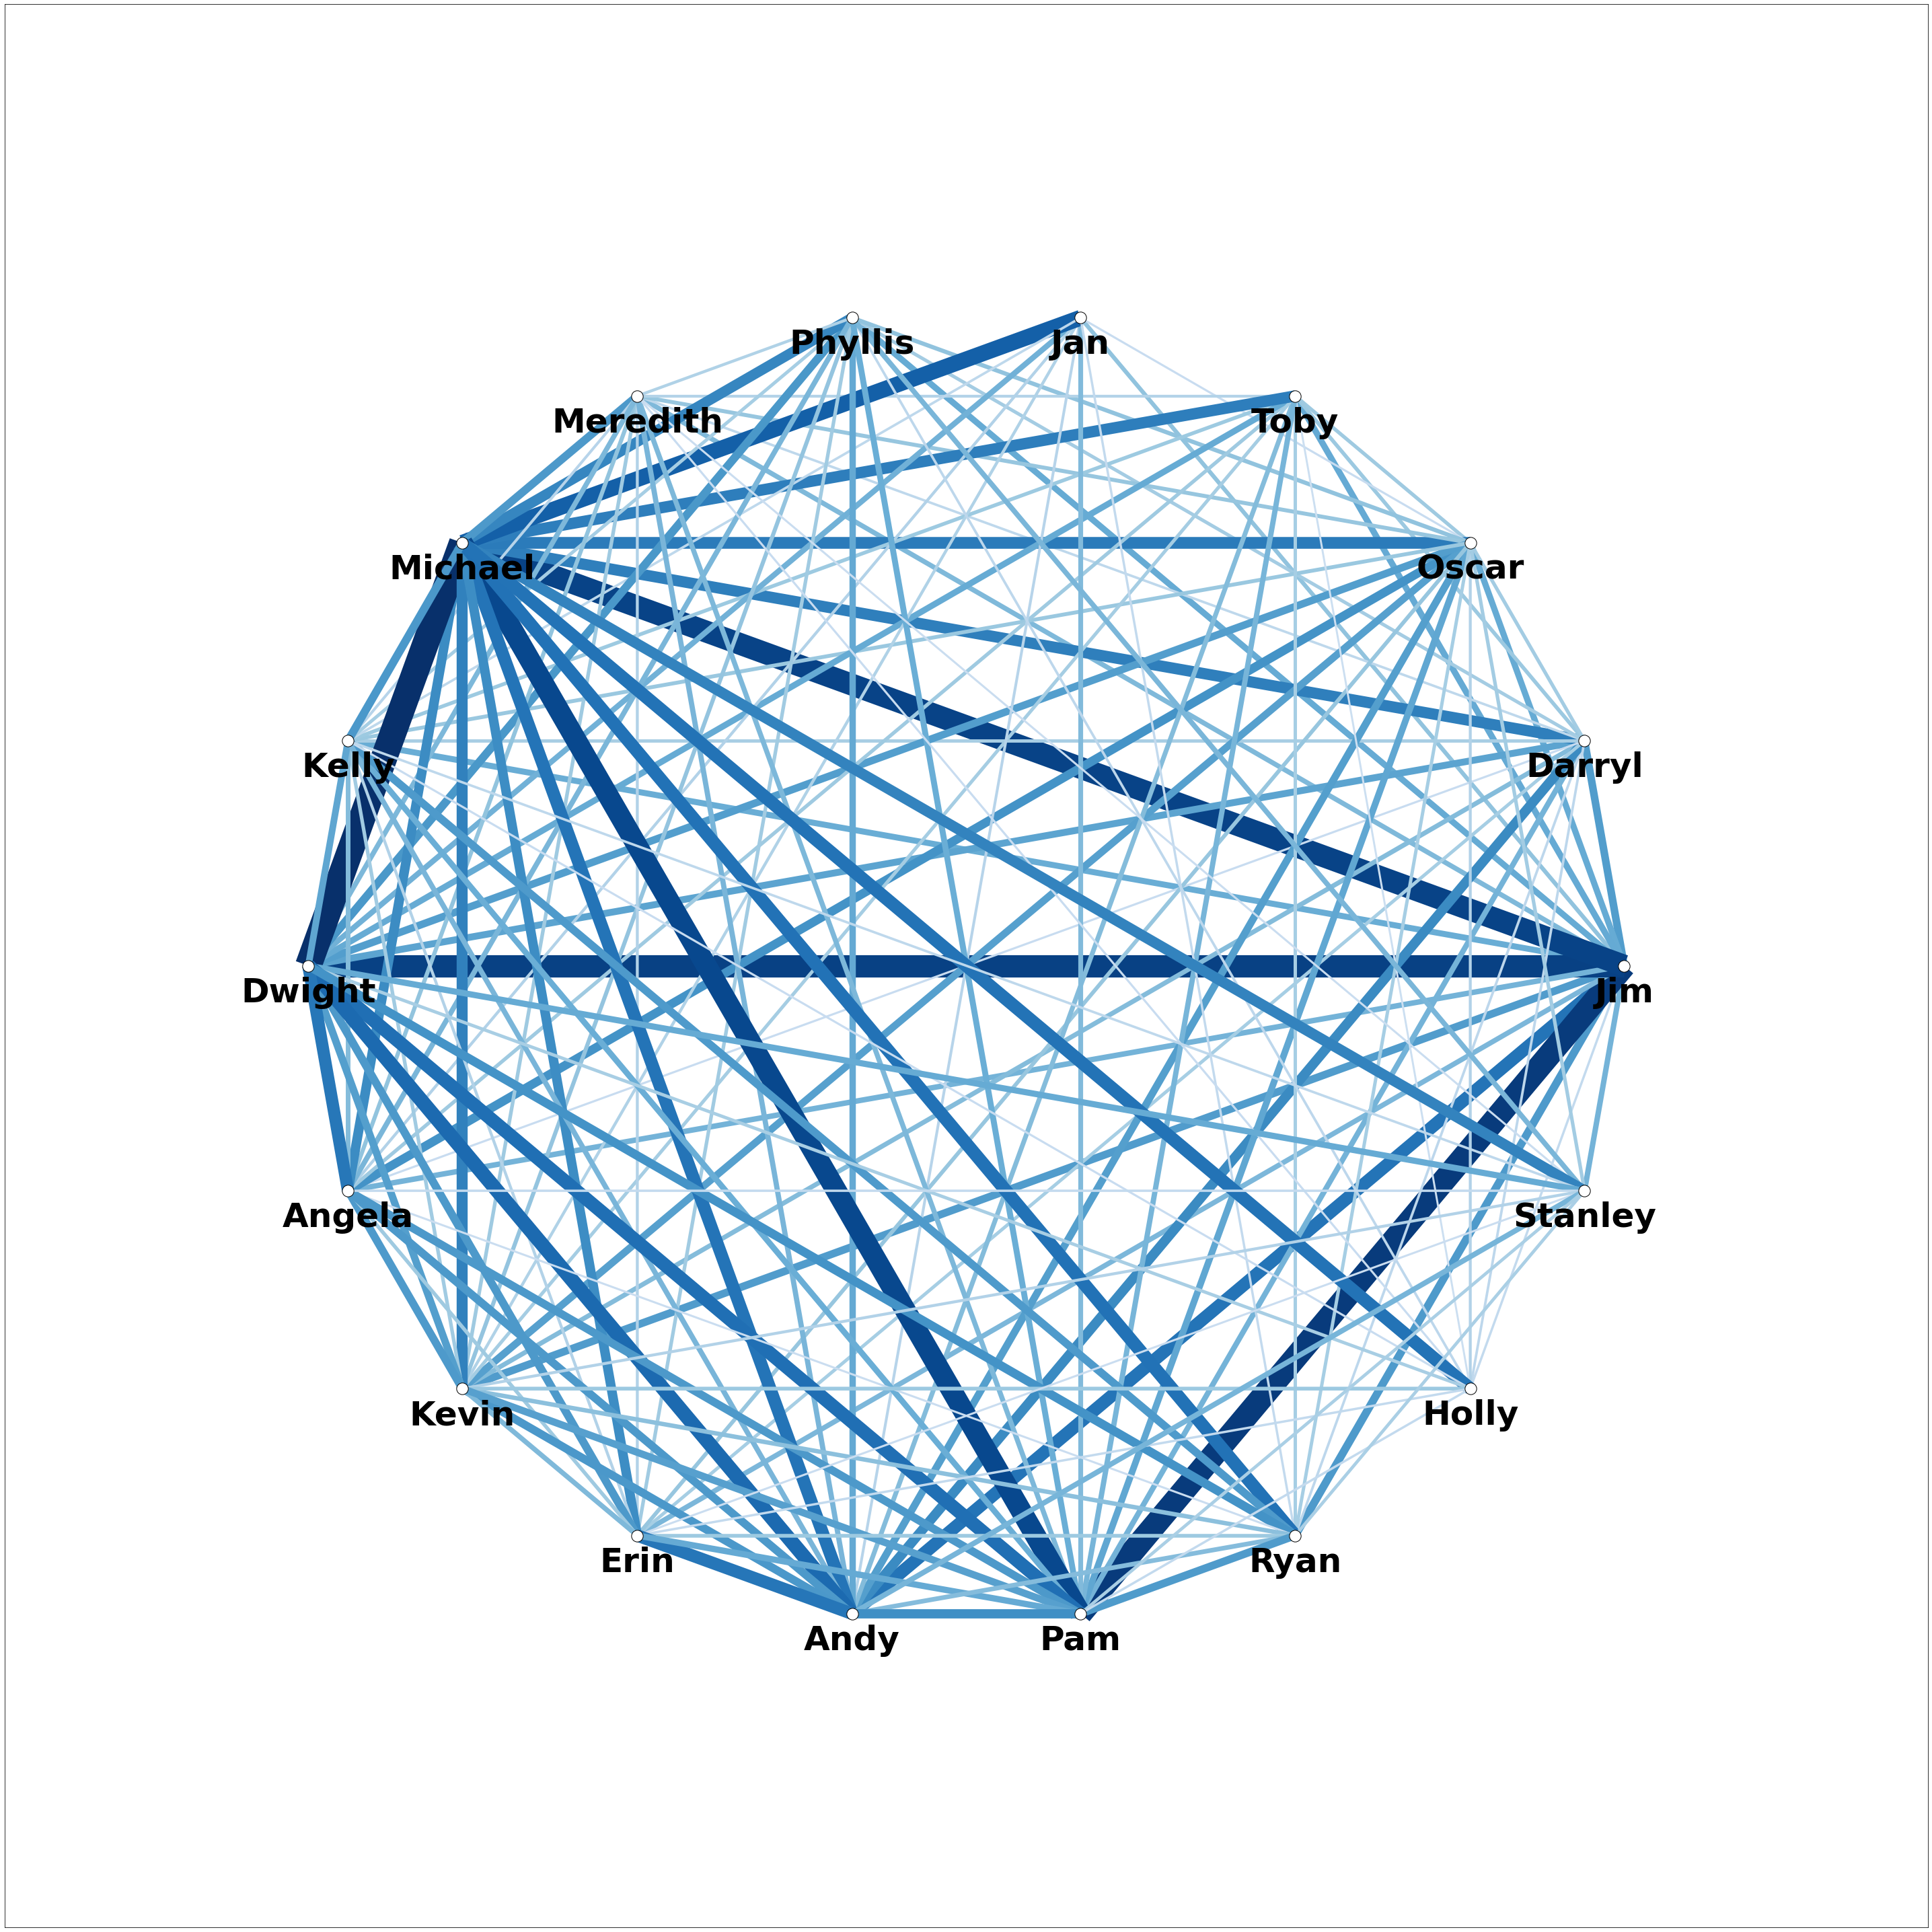

In [340]:
plot_fig_para(G_reorder)